# Financial Time Series
# Asset correlations

## Objective

In this notebook, we explore the pairwise correlations between financial assets in the IBEX35 based on their historical returns. The goal is to:

- Quantify the degree of inter-dependence between asset returns.
- Compare traditional Pearson correlation with Maximum Likelihood (ML) estimation under Laplace assumptions.
- Visualize correlation structures using heatmaps.
- Identify clusters of related assets and potential diversification opportunities.

## Data Preparation

We work with preprocessed log returns estimated in the Data_Exploration_&_Volatility.ipynb notebook, using Laplace distributions fitted to each asset. The correlation analysis is performed on standardized daily log returns.

We use two types of correlation estimates:

- **Pearson Correlation**: Measures linear dependence between two variables.
- **ML-Based Correlation**: Estimated via a likelihood approach assuming a bivariate Laplace model.

Each correlation is then stored in a structured table with asset pairs and their respective coefficients.

## Loading the data and libraries

In [1]:
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.special import kv
from scipy.stats import pearsonr
import itertools

In [2]:
returns = pd.read_csv('../data/log_returns.csv')
returns.tail()

,Date,Close_ACS.MC,Close_ACX.MC,Close_AENA.MC,Close_AMS.MC,Close_ANA.MC,Close_BBVA.MC,Close_BKT.MC,Close_CABK.MC,Close_CLNX.MC,...,Close_MTS.MC,Close_NTGY.MC,Close_RED.MC,Close_REP.MC,Close_ROVI.MC,Close_SAB.MC,Close_SAN.MC,Close_SCYR.MC,Close_SLR.MC,Close_TEF.MC
2599,2025-07-07,0.001768,0.011299,0.007520,0.009063,-0.011243,0.018032,0.012812,0.014256,-0.014236,...,0.016373,-0.009493,-0.001690,-0.002015,-0.022493,0.021024,0.023566,0.003386,-0.029128,-0.001758
2600,2025-07-08,-0.004427,0.019472,0.008120,-0.003389,-0.012747,0.016218,0.001316,-0.003940,-0.014442,...,0.013264,0.002930,-0.005086,0.035272,0.002726,0.014559,0.010359,-0.003951,-0.012392,-0.011057
2601,2025-07-09,0.006192,0.007319,0.024186,0.007609,0.017607,0.017430,0.017815,0.022894,0.001237,...,0.017300,-0.000732,0.001133,-0.004684,0.003623,0.023913,0.023452,0.014041,0.039125,0.004659
2602,2025-07-10,-0.010638,0.013581,-0.005992,0.012554,-0.003886,-0.018553,-0.009955,-0.027642,-0.001547,...,0.035079,-0.008085,-0.013102,0.002735,0.012579,-0.013215,-0.028073,-0.003352,-0.022309,-0.006217
2603,2025-07-11,0.006220,-0.000900,0.003642,-0.005560,0.003239,-0.031580,-0.014017,-0.011970,-0.001549,...,-0.006442,0.000738,-0.000574,0.013563,-0.005371,-0.026623,-0.017729,-0.004487,-0.005409,-0.002230


In [3]:
fit_results = pd.read_csv('../data/returns_fit.csv')
fit_results.head()

,Asset,loc,scale,se_loc,se_scale,p_value,ks_stat
0,SAB.MC,0.000537,0.018248,0.000371,0.000396,0.845136,0.011970
1,BBVA.MC,0.000777,0.014779,0.000361,0.000301,0.583389,0.015146
2,IAG.MC,0.000296,0.019202,0.000460,0.000425,0.422121,0.017165
3,REP.MC,0.000292,0.013568,0.000369,0.000293,0.360047,0.018050
4,MTS.MC,0.000000,0.020146,0.000481,0.000385,0.347119,0.018246


In [4]:
fit_results_normal = pd.read_csv('../data/returns_fit_normal.csv')
fit_results_normal.head()

,Asset,loc,scale,se_loc,se_scale,p_value,ks_stat
0,CLNX.MC,0.000409,0.017584,0.000390,0.000226,9.967196e-06,0.048344
1,ACX.MC,0.000128,0.019733,0.000298,0.000281,9.059962e-06,0.048533
2,CABK.MC,0.000398,0.021391,0.000331,0.000276,8.548122e-07,0.052987
3,RED.MC,0.000189,0.012031,0.000226,0.000166,3.738763e-07,0.054462
4,ITX.MC,0.000217,0.016353,0.000322,0.000228,3.372141e-07,0.054643


## Correlation Visualization

To better understand the relationship between asset pairs, I developed a function that visualizes their **joint return distribution**. This helps assess not only the strength of the linear relationship, but also the **shape of the joint distribution**, particularly relevant when working with non-Gaussian data.

The plot combines:

- A **KDE (Kernel Density Estimate)** of the joint distribution of log returns
- Visual clues about dependence (symmetric elliptical shapes, fat tails, asymmetries)

This method offers an intuitive way to compare asset pairs and support the estimation of correlation.

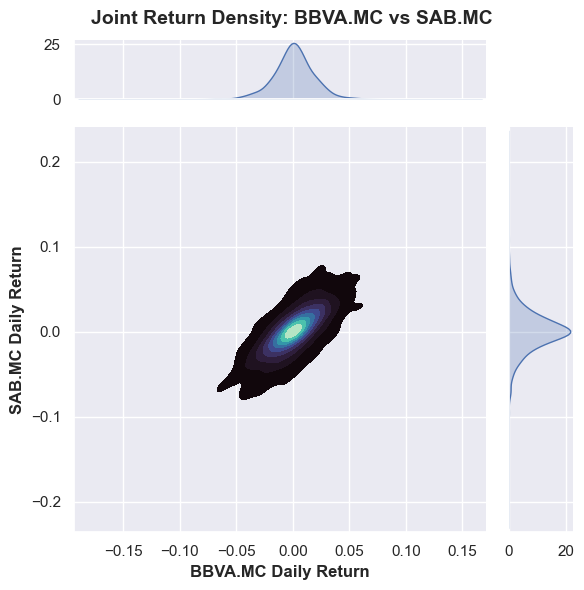

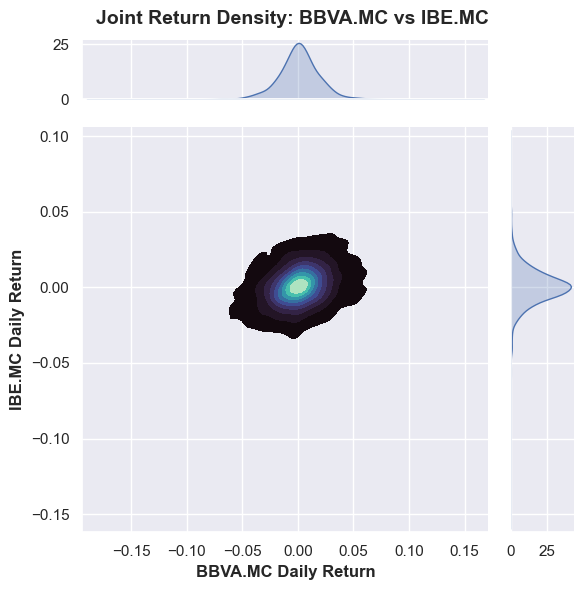

In [5]:
def Asset_Corr(asset1, asset2):
    sns.set(style="darkgrid")
    
    col1 = f"Close_{asset1}"
    col2 = f"Close_{asset2}"
    
    if col1 not in returns.columns or col2 not in returns.columns:
        raise ValueError("One or both asset columns not found in returns DataFrame.")
    
    g = sns.jointplot(
        data=returns, x=col1, y=col2,
        kind="kde", fill=True, cmap="mako",
        height=6, ratio=5, marginal_ticks=True
    )
    
    g.ax_joint.set_xlabel(f"{asset1} Daily Return", fontsize=12, fontweight='bold')
    g.ax_joint.set_ylabel(f"{asset2} Daily Return", fontsize=12, fontweight='bold')


    plt.suptitle(f"Joint Return Density: {asset1} vs {asset2}", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.subplots_adjust(top=0.93) 

    plt.show()

Asset_Corr("BBVA.MC", "SAB.MC")
Asset_Corr("BBVA.MC", "IBE.MC")

As expected, the daily returns of certain asset pairs exhibit strong positive correlations. This is particularly relevant when both tickers belong to companies operating within the same economic sector, such as BBVA and SAB. 

This sectoral structure is a typical feature in financial markets, where companies exposed to similar macroeconomic drivers (e.g., interest rates, commodity prices, regulation) tend to move together as the investor sentiment is more related to the economical sector than to the individual assets. For example, banks, energy providers, or industrial firms often form tightly correlated clusters. 

## Maximum Likehood Estimation

While the sample covariance is enough to estimate the correlation between two gaussian distributed variables, it is not optimal under the assumption of Laplace distributed random variables. In order to estimate then the correlation from first estatistical principles.

First, let's consider the Bivariate Laplace distribution, the multivariate distribution whose marginal distribution are Laplace distributions:
$$
f_X(x_1, x_2) = \frac{1}{\pi \sigma_1 \sigma_2 \sqrt{1-\rho^2}} K_0 \left(\sqrt{\frac{2\left(\frac{x_1^2}{\sigma_1^2} + \frac{x_2^2}{\sigma_2^2} - \frac{2\rho x_1 x_2}{\sigma_1 \sigma_2}\right)}{1-\rho^2}}\right)
$$
where $\sigma_1$ and $\sigma_2$ are the individual asset volatilty, $\rho$ is the correlation coefficient and $K_0$ is a Bessel function defined as:
$$
K_0(x) = \frac{1}{2} \int\limits_{-\infty}^{\infty} \frac{e^{i\omega t}}{\sqrt{t^2 + 1}} \, dt
$$

*Ref*: Kotz. Samuel; Kozubowski, Tomasz J.; Podgorski, Krzysztof (2001). The Laplace Distribution and Generalizations. Birkhauser. pp. 229–245.

Now, before moving to the correlation estimation, we have to assume that the each trading day is independent from the past. This is not true, but as the intention is to model long time behaviour and assets have only short time correlations, it is a reasonable assumption.

$$
g_X(\vec{x}_1, \vec{x}_2| \rho, \sigma_1, \sigma_2) = \prod_{\text{trading days}} f_X(x_1^{(i)}, x_2^{(i)} | \rho, \sigma_1, \sigma_2)
$$

The maximum likehood method relaid in the maximization of the previous funtion $g_X$ (or, as it is often, its logarithm) with the observed data. In this situation, the likehood of the data is:
$$
\mathcal{L}(\vec{x}_1, \vec{x}_2| \rho, \sigma_1, \sigma_2) = ln[g_X(\vec{x}_1, \vec{x}_2| \rho, \sigma_1, \sigma_2)] = -\frac{N}{2}\ln(1-\rho^2) +  \sum_{\text{trading days}} \ln \left[K_0 \left(\sqrt{\frac{2\left(\frac{x_1^2}{\sigma_1^2} + \frac{x_2^2}{\sigma_2^2} - \frac{2\rho x_1 x_2}{\sigma_1 \sigma_2}\right)}{1-\rho^2}}\right)\right]
$$

Although this maximization problem has not closed solution, it is possible to estimate the value of $\rho$ numerically. Note that the $\sigma_1$ and $\sigma_2$ were already estimated in the previous notebook.

In [ ]:
def Likelihood(data, asset1, asset2, results):
    corr = np.linspace(-0.9999, 0.9999, 1001)
    Likl = np.zeros(len(corr))
    
    fit1 = results[results['Asset'] == asset1].iloc[0]
    loc1 = fit1['loc']
    scale1 = fit1['scale']
    pred_vol1 = np.sqrt(2) * scale1 
    
    fit2 = results[results['Asset'] == asset2].iloc[0]
    loc2 = fit2['loc']
    scale2 = fit2['scale']
    pred_vol2 = np.sqrt(2) * scale2

    asset1_returns = (data[f"Close_{asset1}"] - loc1) / pred_vol1
    asset2_returns = (data[f"Close_{asset2}"] - loc2) / pred_vol2
    
    for i, c in enumerate(corr):
        z = np.sqrt(2 * (asset1_returns**2 + asset2_returns**2 - 
                         2 * c * asset1_returns * asset2_returns) / (1 - c**2))
        
        with np.errstate(divide='ignore', invalid='ignore'):
            log_bessel = np.log(kv(0, z))
        
        log_bessel = np.where(np.isfinite(log_bessel), log_bessel, -1e10)
        
        Likl[i] = np.sum(-np.log(np.pi) - 0.5 * np.log(1 - c**2) + log_bessel)
    
    return -Likl

def Plot_Likelihood(data, asset1, asset2, results):
    Likl = -Likelihood(data, asset1, asset2, results)
    corr = np.linspace(-0.9999, 0.9999, len(Likl))

    plt.figure(figsize=(8,5))
    plt.plot(corr, Likl)
    plt.xlabel('correlation')
    plt.ylabel('Likelihood')
    plt.title(f'Likelihood - {asset1} y {asset2}')
    plt.grid(True)
    plt.ylim(Likl[5], 0)
    plt.show()

def Maximum_Likelihood_Correlation_Estimation(data, asset1, asset2, results):
    neg_log_lik = Likelihood(data, asset1, asset2, results)
    corr = np.linspace(-0.9999, 0.9999, len(neg_log_lik))
    min_idx = np.argmin(neg_log_lik)

    corr_est = corr[min_idx]
    
    return corr_est

## Gaussian model

The gaussian correlation coefficient or Pearson coefficient is easier to estimate as its solution is known:
$$
\rho_{Gaussian} = \frac{1}{N\sigma_1\sigma_2} \sum_{\text{Trading days}} \left( x_1^{(i)} - \overline{x}_1 \right)\left( x_2^{(i)} - \overline{x}_2 \right)
$$

In [7]:
def Pearson_coef(data, asset1, asset2, results):
    fit1 = results[results['Asset'] == asset1].iloc[0]
    loc1 = fit1['loc']
    scale1 = fit1['scale']
    pred_vol1 = scale1 

    fit2 = results[results['Asset'] == asset2].iloc[0]
    loc2 = fit2['loc']
    scale2 = fit2['scale']
    pred_vol2 = scale2

    asset1_returns = (data[f"Close_{asset1}"] - loc1) / pred_vol1
    asset2_returns = (data[f"Close_{asset2}"] - loc2) / pred_vol2

    pearson_corr, _ = pearsonr(asset1_returns, asset2_returns)

    return pearson_corr

In [8]:
correlation = pd.DataFrame(columns=['Asset1', 'Asset2', 'ML_Correlation', 'Pearson_Correlation'])
assets = fit_results['Asset'].unique()

for asset1, asset2 in itertools.combinations(assets, 2):
    try:
        ml_corr = Maximum_Likelihood_Correlation_Estimation(returns,  asset1, asset2,  fit_results)
        pearson_corr = Pearson_coef(returns,  asset1, asset2,  fit_results)
    
        correlation = pd.concat([
            correlation,
            pd.DataFrame([{
                'Asset1': asset1,
                'Asset2': asset2,
                'ML_Correlation': ml_corr,
                'Pearson_Correlation': pearson_corr
            }])
        ], ignore_index=True)
    
    except Exception as e:
        print(f"Error processing pair ({asset1}, {asset2}): {e}")

correlation.to_csv("../data/correlations.csv", index=False)

C:\Users\juanc\AppData\Local\Temp\ipykernel_20840\86544699.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  correlation = pd.concat([


## Correlation Heatmaps

The heatmaps below display the correlation matrices:

- **ML-Based Correlation**: Derived from Laplace-distributed returns.
- **Pearson Correlation**: Based on standard covariance calculations.

Higher values indicate stronger co-movement between asset returns. Sectors with internal consistency show denser correlation blocks.

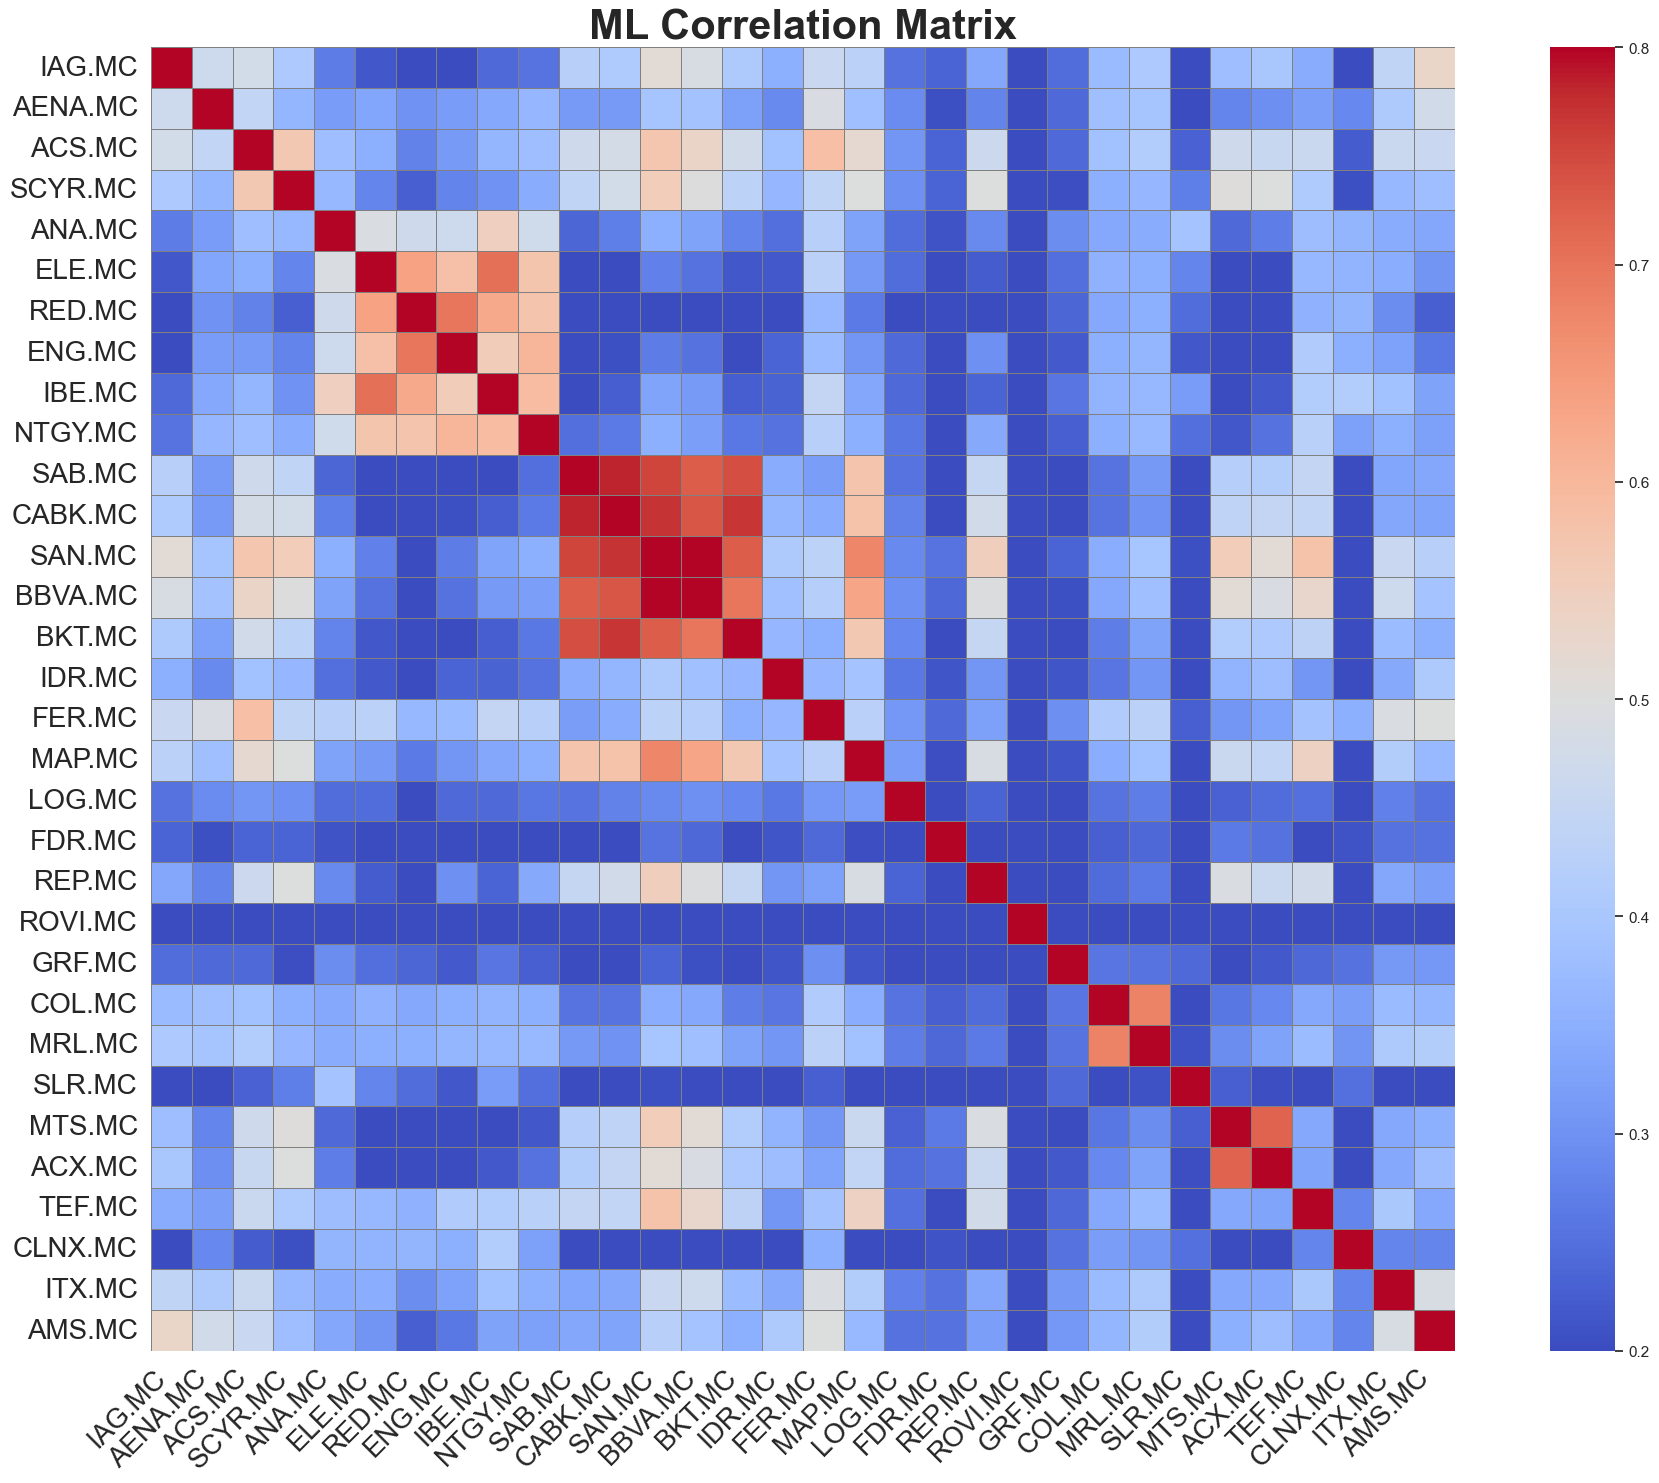

In [9]:
correlation = pd.read_csv('../data/correlations.csv')
corr_type = "ML_Correlation" 

url = 'https://en.wikipedia.org/wiki/IBEX_35#Components'
IBEX35 = pd.read_html(url, header=0)[2]
sector_map = dict(zip(IBEX35['Ticker'], IBEX35['Sector']))

assets = pd.unique(correlation[['Asset1', 'Asset2']].values.ravel())


corr_matrix = pd.DataFrame(index=assets, columns=assets, dtype=float)

assets_df = pd.DataFrame({'Asset': corr_matrix.index})
assets_df['Sector'] = assets_df['Asset'].map(sector_map)
assets_ordered = assets_df.sort_values('Sector')['Asset'].values

corr_matrix = corr_matrix.loc[assets_ordered, assets_ordered]

for _, row in correlation.iterrows():
    a1, a2, val = row['Asset1'], row['Asset2'], row[corr_type]
    corr_matrix.loc[a1, a2] = val
    corr_matrix.loc[a2, a1] = val

for asset in assets:
    corr_matrix.loc[asset, asset] = 1.0

plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix.astype(float), annot=False, cmap="coolwarm", vmin=0.2, vmax=0.8, square=True,
            linewidths=0.5, linecolor='gray')

plt.title(f"{corr_type.replace('_', ' ')} Matrix", fontsize=30, fontweight='bold')
plt.xticks(rotation=45, ha="right", fontsize = 20)
plt.yticks(rotation=0, fontsize = 20)
plt.tight_layout()

plt.savefig("../Outputs/Laplace_correlations.pdf", format="pdf", bbox_inches="tight")
plt.show()

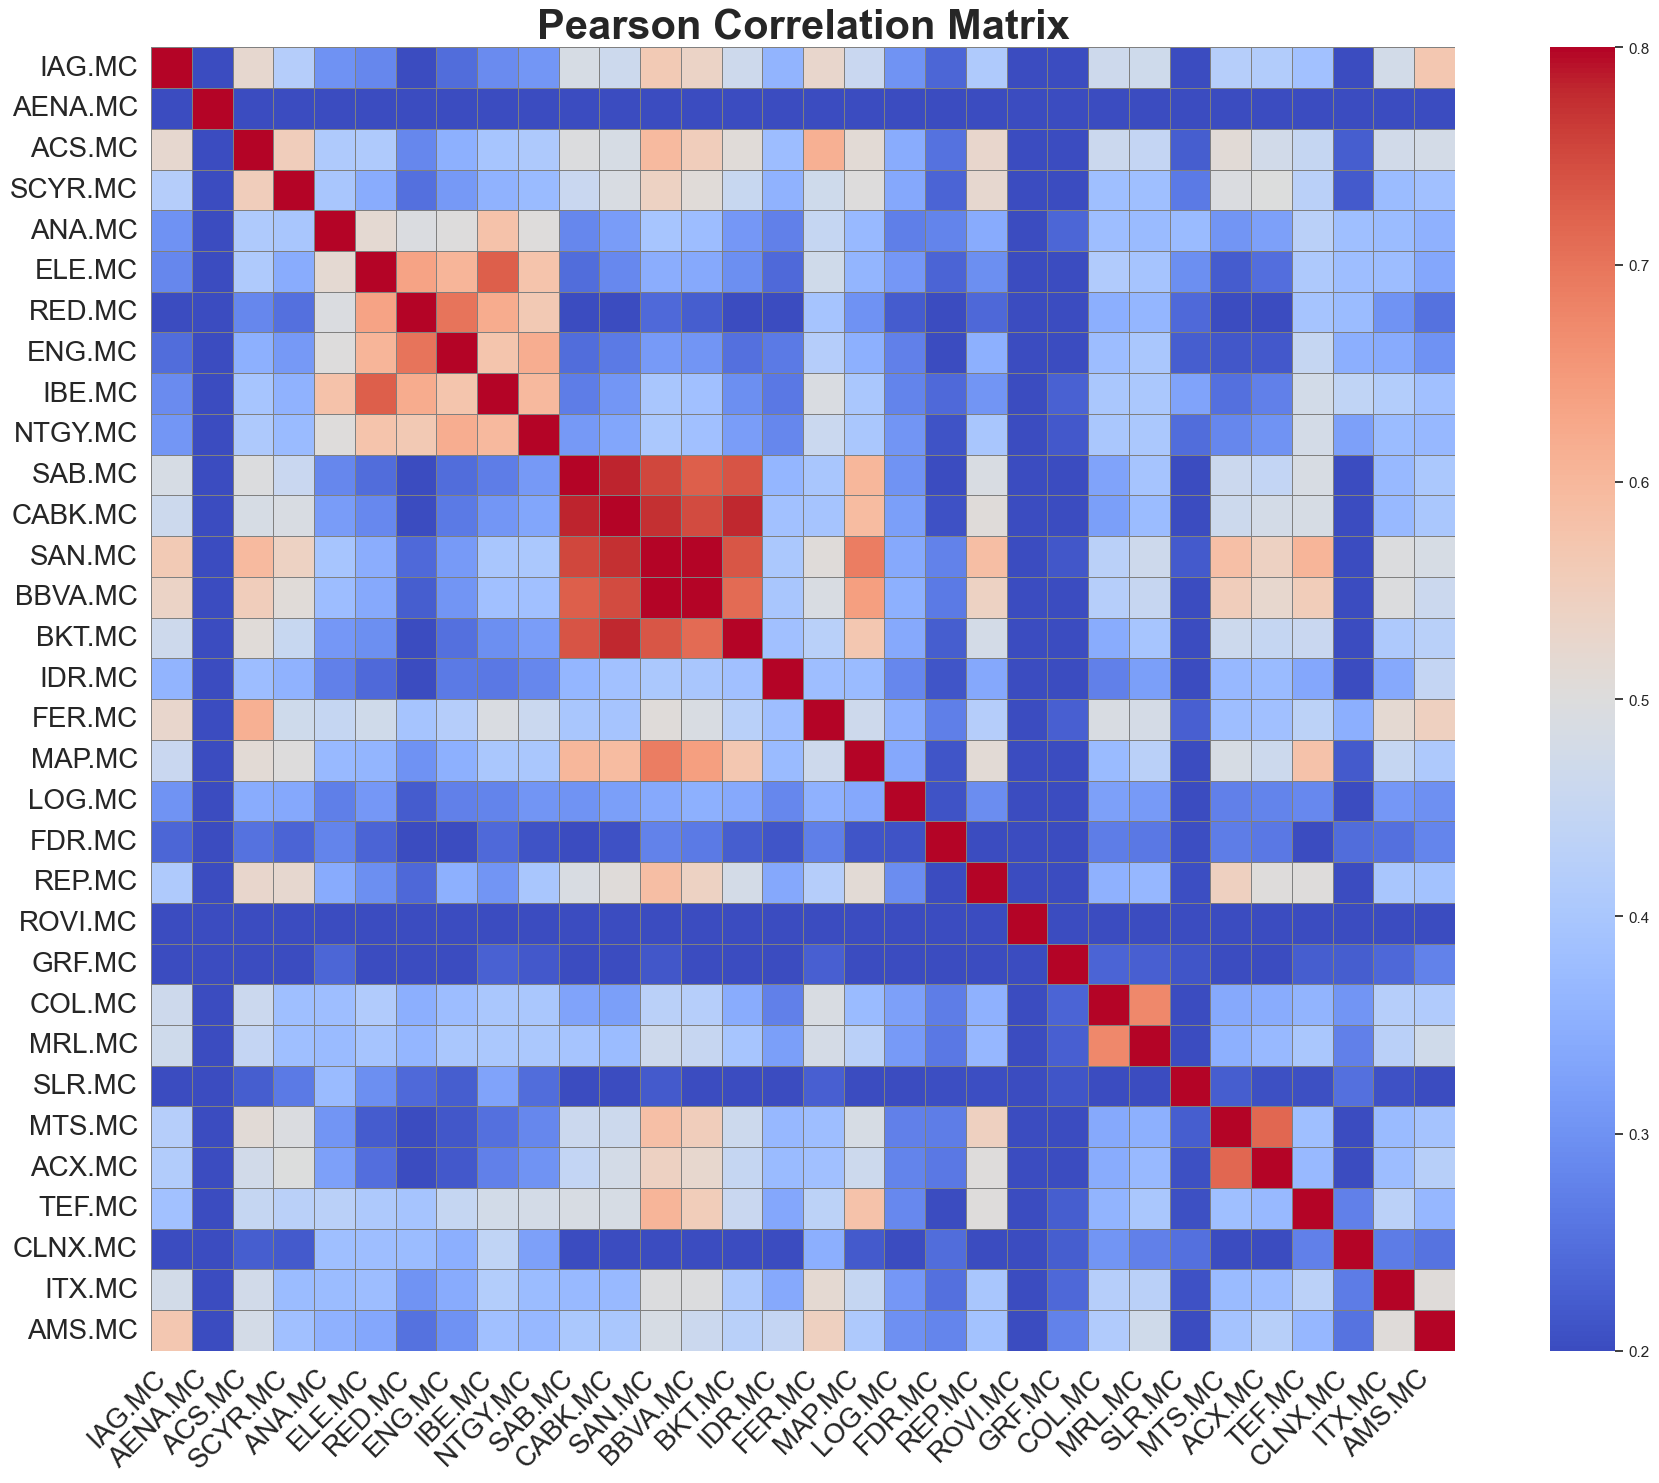

In [10]:
correlation = pd.read_csv('../data/correlations.csv')
corr_type = "Pearson_Correlation" 

url = 'https://en.wikipedia.org/wiki/IBEX_35#Components'
IBEX35 = pd.read_html(url, header=0)[2]
sector_map = dict(zip(IBEX35['Ticker'], IBEX35['Sector']))

assets = pd.unique(correlation[['Asset1', 'Asset2']].values.ravel())


corr_matrix = pd.DataFrame(index=assets, columns=assets, dtype=float)

assets_df = pd.DataFrame({'Asset': corr_matrix.index})
assets_df['Sector'] = assets_df['Asset'].map(sector_map)
assets_ordered = assets_df.sort_values('Sector')['Asset'].values

corr_matrix = corr_matrix.loc[assets_ordered, assets_ordered]

for _, row in correlation.iterrows():
    a1, a2, val = row['Asset1'], row['Asset2'], row[corr_type]
    corr_matrix.loc[a1, a2] = val
    corr_matrix.loc[a2, a1] = val

for asset in assets:
    corr_matrix.loc[asset, asset] = 1.0

plt.figure(figsize=(20, 15))
sns.heatmap(corr_matrix.astype(float), annot=False, cmap="coolwarm", vmin=0.2, vmax=0.8, square=True,
            linewidths=0.5, linecolor='gray')

plt.title(f"{corr_type.replace('_', ' ')} Matrix", fontsize=30, fontweight='bold')
plt.xticks(rotation=45, ha="right", fontsize = 20)
plt.yticks(rotation=0, fontsize = 20)
plt.tight_layout()

plt.savefig("../Outputs/Gaussian_correlations.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Interpretation

- Assets within the same sector generally show stronger positive correlations.
- ML correlations are often more robust to outliers, especially in assets with heavy-tailed returns.
- Diversification is more effective when selecting assets with lower correlations.

We also observe that financial institutions, energy companies, and utilities tend to form strong intra-sector clusters.


## Next Steps

- Use the correlation matrix to construct a minimum variance portfolio.
- Apply correlation networks to identify influential or central assets.
- Compare correlation structures under different market regimes or time windows. This falls out of the scope of this project.

This correlation analysis serves as a foundation for portfolio optimization and risk modeling in subsequent notebooks.
